# Capstone Project
## Image classifier for the SVHN dataset
### Instructions

In this notebook, you will create a neural network that classifies real-world images digits. You will use concepts from throughout this course in building, training, testing, validating and saving your Tensorflow classifier model.

This project is peer-assessed. Within this notebook you will find instructions in each section for how to complete the project. Pay close attention to the instructions as the peer review will be carried out according to a grading rubric that checks key parts of the project instructions. Feel free to add extra cells into the notebook as required.

### How to submit

When you have completed the Capstone project notebook, you will submit a pdf of the notebook for peer review. First ensure that the notebook has been fully executed from beginning to end, and all of the cell outputs are visible. This is important, as the grading rubric depends on the reviewer being able to view the outputs of your notebook. Save the notebook as a pdf (File -> Download as -> PDF via LaTeX). You should then submit this pdf for review.

### Let's get started!

We'll start by running some imports, and loading the dataset. For this project you are free to make further imports throughout the notebook as you wish. 

In [1]:
import tensorflow as tf
from scipy.io import loadmat
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

![SVHN overview image](data/svhn_examples.jpg)
For the capstone project, you will use the [SVHN dataset](http://ufldl.stanford.edu/housenumbers/). This is an  image dataset of over 600,000 digit images in all, and is a harder dataset than MNIST as the numbers appear in the context of natural scene images. SVHN is obtained from house numbers in Google Street View images. 

* Y. Netzer, T. Wang, A. Coates, A. Bissacco, B. Wu and A. Y. Ng. "Reading Digits in Natural Images with Unsupervised Feature Learning". NIPS Workshop on Deep Learning and Unsupervised Feature Learning, 2011.

Your goal is to develop an end-to-end workflow for building, training, validating, evaluating and saving a neural network that classifies a real-world image into one of ten classes.

In [2]:
# Run this cell to load the dataset

train = loadmat('data/train_32x32.mat')
test = loadmat('data/test_32x32.mat')

Both `train` and `test` are dictionaries with keys `X` and `y` for the input images and labels respectively.

## 1. Inspect and preprocess the dataset
* Extract the training and testing images and labels separately from the train and test dictionaries loaded for you.
* Select a random sample of images and corresponding labels from the dataset (at least 10), and display them in a figure.
* Convert the training and test images to grayscale by taking the average across all colour channels for each pixel. _Hint: retain the channel dimension, which will now have size 1._
* Select a random sample of the grayscale images and corresponding labels from the dataset (at least 10), and display them in a figure.

In [3]:
#read data and transform it from (x,y,c,n) to (n,x,y,c) format
x,y,c,n=train['X'].shape
x_train=train['X'].reshape(-1,n).T.reshape(n,x,y,c)
y_train=train['y']

x,y,c,m=test['X'].shape
x_test=test['X'].reshape(-1,m).T.reshape(m,x,y,c)
y_test=test['y']

print("train data shape: ",x_train.shape)
print("test data shape: ",x_test.shape)

train data shape:  (73257, 32, 32, 3)
test data shape:  (26032, 32, 32, 3)


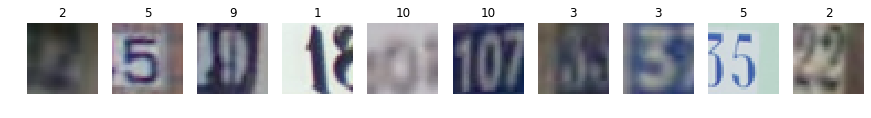

In [4]:
#randomly display 10 images and its value
random_inx = np.random.choice(x_train.shape[0],10)

fig, ax = plt.subplots(1, 10, figsize=(15, 1.5))
for i, index in enumerate(random_inx):
    ax[i].set_axis_off()
    ax[i].imshow(x_train[index])
    ax[i].set_title(str(y_train[index,0]))

In [5]:
# convert to grayscale image
x_train_gs=x_train.mean(axis=-1)[...,np.newaxis] #[...,np.newaxis]
x_test_gs=x_test.mean(axis=-1)[...,np.newaxis] #[...,np.newaxis]
x_train_gs.shape

(73257, 32, 32, 1)

In [6]:
y_train_gs=y_train.reshape(n,)
y_test_gs=y_test.reshape(m,)
y_train_gs.shape

(73257,)

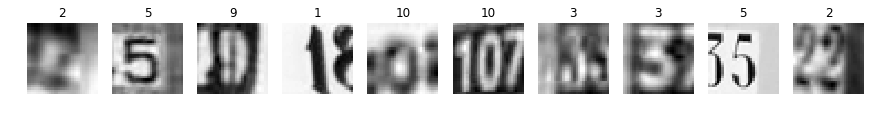

In [7]:
# display the 10 images in gray scale from the gray scale dataset
fig, ax = plt.subplots(1, 10, figsize=(15, 1.5))
for i, index in enumerate(random_inx):
    ax[i].set_axis_off()
    ax[i].imshow(x_train_gs[index,:,:,0],cmap='gray')
    ax[i].set_title(str(y_train_gs[index]))


In [8]:
x_train_gs=x_train_gs/255.0
x_test_gs=x_test_gs/255.0

## 2. MLP neural network classifier
* Build an MLP classifier model using the Sequential API. Your model should use only Flatten and Dense layers, with the final layer having a 10-way softmax output. 
* You should design and build the model yourself. Feel free to experiment with different MLP architectures. _Hint: to achieve a reasonable accuracy you won't need to use more than 4 or 5 layers._
* Print out the model summary (using the summary() method)
* Compile and train the model (we recommend a maximum of 30 epochs), making use of both training and validation sets during the training run. 
* Your model should track at least one appropriate metric, and use at least two callbacks during training, one of which should be a ModelCheckpoint callback.
* As a guide, you should aim to achieve a final categorical cross entropy training loss of less than 1.0 (the validation loss might be higher).
* Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
* Compute and display the loss and accuracy of the trained model on the test set.

In [9]:
# Build MLP model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense

model=Sequential([
    Flatten(input_shape=(32,32,1)),
    Dense(512, activation='relu', name='Layer_1'),
    Dense(128, activation='relu', name='Layer_2'),
    Dense(64, activation='relu', name='Layer_3'),
    Dense(11, activation='softmax')    
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
Layer_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
Layer_2 (Dense)              (None, 128)               65664     
_________________________________________________________________
Layer_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense (Dense)                (None, 11)                715       
Total params: 599,435
Trainable params: 599,435
Non-trainable params: 0
_________________________________________________________________


In [10]:
# create callback functions
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import Callback

def get_checkpoint_best_only():
    """
    This function should return a ModelCheckpoint object that:
    - saves only the weights that generate the lowest loss
    - saves into a directory called 'checkpoints_best_only' inside the current working directory
    - generates a file called 'checkpoints_best_only/checkpoint' 
    """
    check_best_path='checkpoints_best_only/checkpoint'
    checkpoint_best=ModelCheckpoint(filepath=check_best_path,
                               save_weights_only=True,
                               save_freq='epoch',
                               monitor='loss',
                               mode='min',
                               save_best_only=True,
                               verbose=1)
    return checkpoint_best

def get_early_stopping():
    """
    This function should return an EarlyStopping callback that stops training when
    the validation (testing) accuracy has not improved in the last 3 epochs.
    HINT: use the EarlyStopping callback with the correct 'monitor' and 'patience'
    """
    early_stop=tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
    return early_stop

checkpoint_best_only = get_checkpoint_best_only()
early_stop = get_early_stopping()
my_callback=[checkpoint_best_only,early_stop]

In [11]:
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
history=model.fit(x=x_train_gs,
                 y=y_train_gs,
                 epochs=30,                 
                 batch_size=128,
                 validation_split=0.15,
                 callbacks=my_callback)

Train on 62268 samples, validate on 10989 samples
Epoch 1/30
61952/62268 [============================>.] - ETA: 0s - loss: 2.1823 - accuracy: 0.2145
Epoch 00001: loss improved from inf to 2.18101, saving model to checkpoints_best_only/checkpoint
62268/62268 [==============================] - 22s 354us/sample - loss: 2.1810 - accuracy: 0.2151 - val_loss: 1.9329 - val_accuracy: 0.3216
Epoch 2/30
62080/62268 [============================>.] - ETA: 0s - loss: 1.5774 - accuracy: 0.4672
Epoch 00002: loss improved from 2.18101 to 1.57682, saving model to checkpoints_best_only/checkpoint
62268/62268 [==============================] - 20s 322us/sample - loss: 1.5768 - accuracy: 0.4675 - val_loss: 1.3538 - val_accuracy: 0.5517
Epoch 3/30
62080/62268 [============================>.] - ETA: 0s - loss: 1.2196 - accuracy: 0.6091
Epoch 00003: loss improved from 1.57682 to 1.21906, saving model to checkpoints_best_only/checkpoint
62268/62268 [==============================] - 20s 323us/sample - loss:

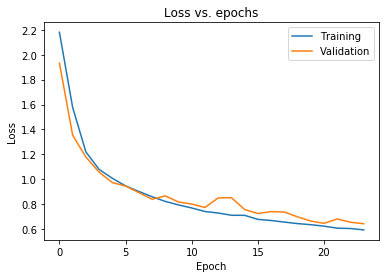

In [12]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

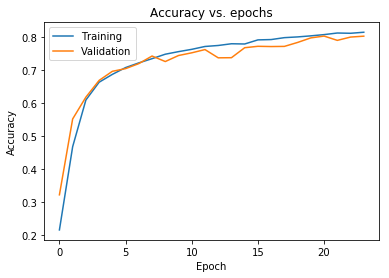

In [13]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

In [14]:
model.evaluate(x_test_gs,y_test_gs, verbose=2)

26032/1 - 6s - loss: 0.5903 - accuracy: 0.7801


[0.7435531291627562, 0.7801168]

## 3. CNN neural network classifier
* Build a CNN classifier model using the Sequential API. Your model should use the Conv2D, MaxPool2D, BatchNormalization, Flatten, Dense and Dropout layers. The final layer should again have a 10-way softmax output. 
* You should design and build the model yourself. Feel free to experiment with different CNN architectures. _Hint: to achieve a reasonable accuracy you won't need to use more than 2 or 3 convolutional layers and 2 fully connected layers.)_
* The CNN model should use fewer trainable parameters than your MLP model.
* Compile and train the model (we recommend a maximum of 30 epochs), making use of both training and validation sets during the training run.
* Your model should track at least one appropriate metric, and use at least two callbacks during training, one of which should be a ModelCheckpoint callback.
* You should aim to beat the MLP model performance with fewer parameters!
* Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
* Compute and display the loss and accuracy of the trained model on the test set.

In [15]:
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D

model_cnn = Sequential([
        Conv2D(filters=16, input_shape=(32, 32, 1), kernel_size=(3, 3), 
               activation='relu', name='conv_1'),
        MaxPooling2D(pool_size=(2, 2), name='pool_1'),
        Conv2D(filters=8, kernel_size=(3, 3), activation='relu', name='conv_2'),
        MaxPooling2D(pool_size=(2, 2), name='pool_2'),
        Flatten(name='flatten'),
        Dense(units=32, activation='relu', name='dense_1'),
        Dense(units=11, activation='softmax', name='dense_2')
    ])
model_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              (None, 30, 30, 16)        160       
_________________________________________________________________
pool_1 (MaxPooling2D)        (None, 15, 15, 16)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 13, 13, 8)         1160      
_________________________________________________________________
pool_2 (MaxPooling2D)        (None, 6, 6, 8)           0         
_________________________________________________________________
flatten (Flatten)            (None, 288)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                9248      
_________________________________________________________________
dense_2 (Dense)              (None, 11)               

In [16]:
# create callback functions

def cnn_get_checkpoint_best_only():
    """
    This function should return a ModelCheckpoint object that:
    - saves only the weights that generate the lowest loss
    - saves into a directory called 'checkpoints_best_only' inside the current working directory
    - generates a file called 'checkpoints_best_only/checkpoint' 
    """
    check_best_path='cnn_checkpoints_best_only/checkpoint'
    checkpoint_best=ModelCheckpoint(filepath=check_best_path,
                               save_weights_only=True,
                               save_freq='epoch',
                               monitor='loss',
                               mode='min',
                               save_best_only=True,
                               verbose=1)
    return checkpoint_best

def get_early_stopping():
    """
    This function should return an EarlyStopping callback that stops training when
    the validation (testing) accuracy has not improved in the last 3 epochs.
    HINT: use the EarlyStopping callback with the correct 'monitor' and 'patience'
    """
    early_stop=tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
    return early_stop

cnn_checkpoint_best_only = cnn_get_checkpoint_best_only()
early_stop = get_early_stopping()
my_callback_cnn=[cnn_checkpoint_best_only,early_stop]

In [17]:
model_cnn.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
cnn_history=model_cnn.fit(x=x_train_gs,
                 y=y_train_gs,
                 epochs=30,                 
                 batch_size=128,
                 validation_split=0.15,
                 callbacks=my_callback_cnn)

Train on 62268 samples, validate on 10989 samples
Epoch 1/30
62208/62268 [============================>.] - ETA: 0s - loss: 1.9422 - accuracy: 0.3345
Epoch 00001: loss improved from inf to 1.94148, saving model to cnn_checkpoints_best_only/checkpoint
62268/62268 [==============================] - 110s 2ms/sample - loss: 1.9415 - accuracy: 0.3348 - val_loss: 1.3513 - val_accuracy: 0.5671
Epoch 2/30
62208/62268 [============================>.] - ETA: 0s - loss: 1.1226 - accuracy: 0.6518
Epoch 00002: loss improved from 1.94148 to 1.12245, saving model to cnn_checkpoints_best_only/checkpoint
62268/62268 [==============================] - 106s 2ms/sample - loss: 1.1225 - accuracy: 0.6518 - val_loss: 0.9514 - val_accuracy: 0.7186
Epoch 3/30
62208/62268 [============================>.] - ETA: 0s - loss: 0.8650 - accuracy: 0.7450
Epoch 00003: loss improved from 1.12245 to 0.86486, saving model to cnn_checkpoints_best_only/checkpoint
62268/62268 [==============================] - 107s 2ms/sampl

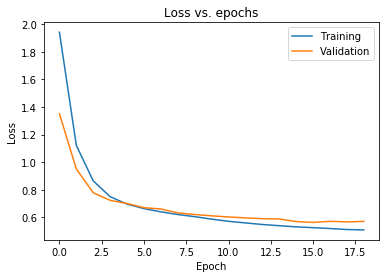

In [18]:
plt.plot(cnn_history.history['loss'])
plt.plot(cnn_history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

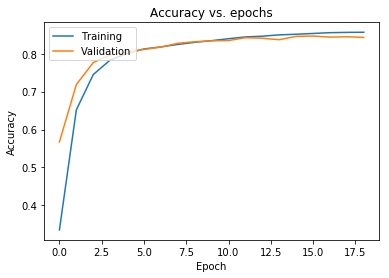

In [19]:
plt.plot(cnn_history.history['accuracy'])
plt.plot(cnn_history.history['val_accuracy'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

In [20]:
model_cnn.evaluate(x_test_gs,y_test_gs, verbose=2)

26032/1 - 19s - loss: 0.4733 - accuracy: 0.8309


[0.6391843655264003, 0.83086205]

## 4. Get model predictions
* Load the best weights for the MLP and CNN models that you saved during the training run.
* Randomly select 5 images and corresponding labels from the test set and display the images with their labels.
* Alongside the image and label, show each model’s predictive distribution as a bar chart, and the final model prediction given by the label with maximum probability.

In [21]:
#define a function to get the model and saved weight
def get_model_best_epoch(model,folder_path):
    """
    This function should create a new instance of the CNN you created earlier, load 
    on the weights leading to the highest validation accuracy, and return this model.
    """
    filename=tf.train.latest_checkpoint(folder_path)
    model.load_weights(filename)
    return model

In [22]:
MLP_best_epoch = get_model_best_epoch(model,"checkpoints_best_only/" )
CNN_best_epoch = get_model_best_epoch(model_cnn,"cnn_checkpoints_best_only/" )

print('MLP with best epoch weights:')
MLP_best_epoch.evaluate(x_test_gs,y_test_gs, verbose=2)

print('CNN with best epoch weights:')
CNN_best_epoch.evaluate(x_test_gs,y_test_gs, verbose=2)

MLP with best epoch weights:
26032/1 - 6s - loss: 0.5903 - accuracy: 0.7801
CNN with best epoch weights:
26032/1 - 20s - loss: 0.4733 - accuracy: 0.8309


[0.6391843655264003, 0.83086205]

In [29]:
#randomly select 5 images
random_5 = np.random.choice(x_test.shape[0],5)

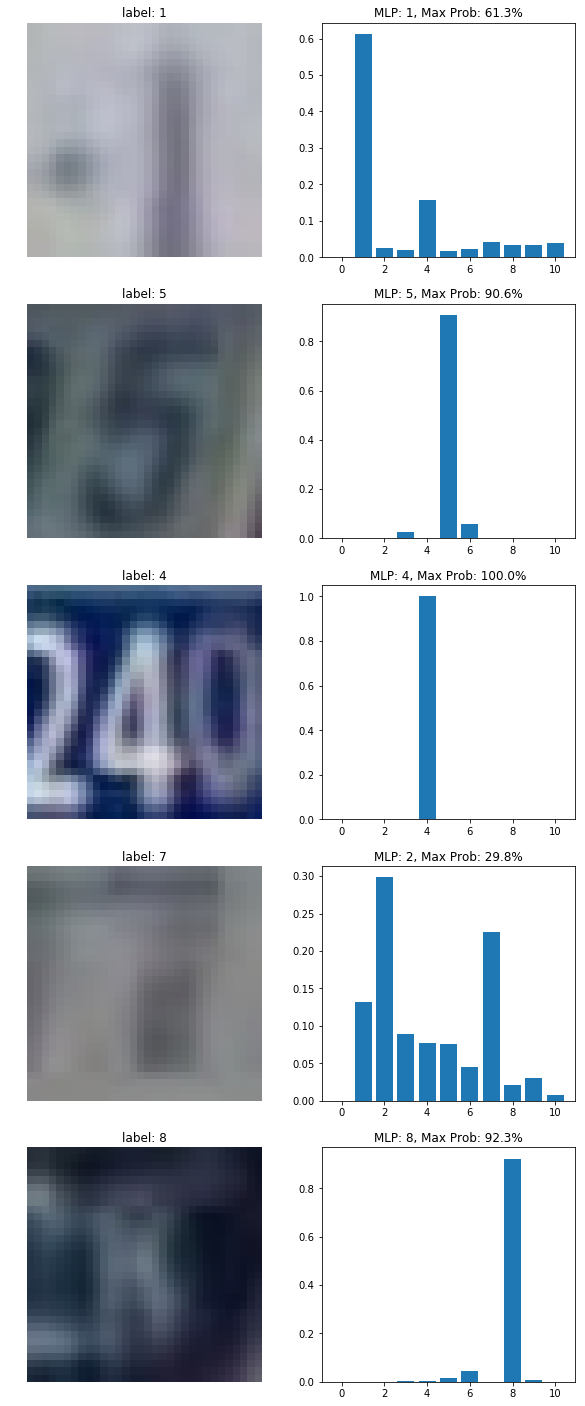

In [30]:
#MLP prediction
fig, ax = plt.subplots(5, 2, figsize=(10, 25))
for i, index in enumerate(random_5):
    ax[i,0].set_axis_off()
    ax[i,0].imshow(x_test[index])
    ax[i,0].set_title("label: "+str(y_test[index,0]))
    pred=MLP_best_epoch.predict(x_test_gs[index][np.newaxis,...])
    ax[i,1].bar(range(11),pred[0])
    t="MLP: "+ str(np.argmax(pred[0]))+", Max Prob: "+ str(f"{100*pred[0].max():3.1f}%")
    ax[i,1].set_title(t)


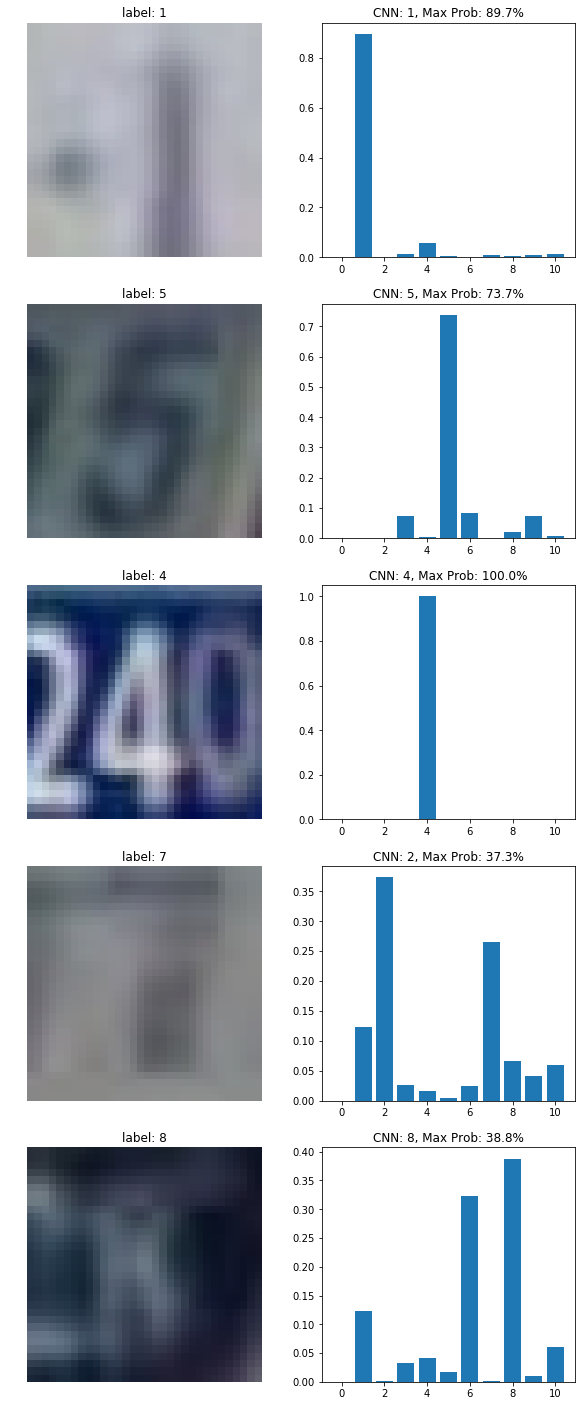

In [31]:
#CNN prediction
fig, ax = plt.subplots(5, 2, figsize=(10, 25))
for i, index in enumerate(random_5):
    ax[i,0].set_axis_off()
    ax[i,0].imshow(x_test[index])
    ax[i,0].set_title("label: "+str(y_test[index,0]))
    pred=CNN_best_epoch.predict(x_test_gs[index][np.newaxis,...])
    ax[i,1].bar(range(11),pred[0])
    t="CNN: "+ str(np.argmax(pred[0]))+", Max Prob: "+ str(f"{100*pred[0].max():3.1f}%")
    ax[i,1].set_title(t)